<a href="https://colab.research.google.com/github/shiranimehr/Capstone-Three/blob/main/Capstone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib
import os.path
from os import path
import matplotlib.image as mpimg 
import PIL
import random
import datetime
import os
import shutil
from google.colab import drive
import requests
import cv2
import keras
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import confusion_matrix

Mount drive:

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
metaData = pd.read_csv('https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv')
metaData.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [4]:
metaData.describe()


,offset,age,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count
count,697.000000,713.000000,78.000000,119.000000,16.000000,28.000000,40.000000
mean,9.083214,53.534362,38.898718,78.475630,5.024375,5.307143,4.638050
std,31.664077,16.949007,6.494383,38.742573,2.660341,3.489956,20.550033
min,-360.000000,18.000000,36.000000,20.000000,0.220000,0.000000,0.400000
25%,1.000000,40.000000,37.800000,55.000000,3.067500,2.725000,0.746500
50%,5.000000,54.000000,38.150000,85.000000,4.745000,4.800000,1.100000
75%,10.000000,68.000000,38.975000,95.000000,6.857500,6.925000,1.600000
max,365.000000,94.000000,95.000000,340.000000,11.200000,12.900000,131.000000


In [5]:
metaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               950 non-null    object 
 1   offset                  697 non-null    float64
 2   sex                     870 non-null    object 
 3   age                     713 non-null    float64
 4   finding                 950 non-null    object 
 5   RT_PCR_positive         593 non-null    object 
 6   survival                361 non-null    object 
 7   intubated               248 non-null    object 
 8   intubation_present      250 non-null    object 
 9   went_icu                397 non-null    object 
 10  in_icu                  335 non-null    object 
 11  needed_supplemental_O2  90 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             78 non-null     float64
 14  pO2_saturation          119 non-null    fl

In [6]:
metaData['date'].fillna(method='ffill', inplace=True)

Drop extra columns:

In [7]:
drop_column_list = ['needed_supplemental_O2', 'extubated', 
                    'temperature', 'pO2_saturation', 'leukocyte_count',
                    'neutrophil_count', 'lymphocyte_count',
                    'doi','url', 'license', 'clinical_notes', 'other_notes']
metaData.drop(drop_column_list, axis=1, inplace=True)

Fill NAs:

In [8]:
metaData['sex'].fillna('Unknown', inplace=True)
metaData['RT_PCR_positive'].fillna('Unknown', inplace=True)
metaData['survival'].fillna('Unknown', inplace=True)
metaData['intubated'].fillna('Unknown', inplace=True)
metaData['intubation_present'].fillna('Unknown', inplace=True)
metaData['went_icu'].fillna('Unknown', inplace=True)
metaData['in_icu'].fillna('Unknown', inplace=True)
metaData['location'].fillna('Unknown', inplace=True)

In [9]:
metaData['offset'].fillna(np.mean(metaData['offset']), inplace=True)
metaData['age'].fillna(np.mean(metaData['age']), inplace=True)

In [10]:
 metaData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patientid           950 non-null    object 
 1   offset              950 non-null    float64
 2   sex                 950 non-null    object 
 3   age                 950 non-null    float64
 4   finding             950 non-null    object 
 5   RT_PCR_positive     950 non-null    object 
 6   survival            950 non-null    object 
 7   intubated           950 non-null    object 
 8   intubation_present  950 non-null    object 
 9   went_icu            950 non-null    object 
 10  in_icu              950 non-null    object 
 11  view                950 non-null    object 
 12  modality            950 non-null    object 
 13  date                950 non-null    object 
 14  location            950 non-null    object 
 15  folder              950 non-null    object 
 16  filename

Check for duplicates:

In [11]:
metaData.drop_duplicates(inplace=True)

In [12]:
metaData['finding'].unique()

array(['Pneumonia/Viral/COVID-19', 'Pneumonia', 'Pneumonia/Viral/SARS',
       'Pneumonia/Fungal/Pneumocystis',
       'Pneumonia/Bacterial/Streptococcus', 'No Finding',
       'Pneumonia/Bacterial/Chlamydophila', 'Pneumonia/Bacterial/E.Coli',
       'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella',
       'Unknown', 'Pneumonia/Lipoid', 'Pneumonia/Viral/Varicella',
       'Pneumonia/Bacterial', 'Pneumonia/Bacterial/Mycoplasma',
       'Pneumonia/Viral/Influenza', 'todo', 'Tuberculosis',
       'Pneumonia/Viral/Influenza/H1N1', 'Pneumonia/Fungal/Aspergillosis',
       'Pneumonia/Viral/Herpes ', 'Pneumonia/Aspiration',
       'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/MERS-CoV',
       'Pneumonia/Bacterial/Staphylococcus/MRSA'], dtype=object)

Add a binary column for COVID-19: 

In [13]:
metaData['COVID-19'] = metaData['finding'].apply(lambda x: True if ('COVID-19' in x) else False)

Get images and drop records with no image:

In [14]:
#image_directory = '../Data/images'
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/"

remove_row_list = []
for i in range(metaData.shape[0]):
    filename = metaData.iloc[i,:]['filename']
    try:
      ret = urllib.request.urlopen(url+filename)
    except:
      print(i, filename, "not found")
      remove_row_list.append(i)

metaData.drop(remove_row_list, axis=0, inplace=True)

53 radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii.gz not found
56 radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii.gz not found
225 coronacases_org_001.nii.gz not found
226 coronacases_org_002.nii.gz not found
227 coronacases_org_003.nii.gz not found
228 coronacases_org_004.nii.gz not found
229 coronacases_org_005.nii.gz not found
230 coronacases_org_006.nii.gz not found
231 coronacases_org_007.nii.gz not found
232 coronacases_org_008.nii.gz not found
233 coronacases_org_009.nii.gz not found
234 coronacases_org_010.nii.gz not found
235 radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.nii.gz not found
236 radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii.gz not found
237 radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii.gz not found
241 radiopaedia_org_covid-19-pneumonia-23_86359_0-dcm.nii.gz not found
242 radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii.gz not found
243 radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii.gz not found
244 radiopaedia_org_covid-

In [15]:
metaData.shape

(929, 19)

In [16]:
metaData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 0 to 949
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patientid           929 non-null    object 
 1   offset              929 non-null    float64
 2   sex                 929 non-null    object 
 3   age                 929 non-null    float64
 4   finding             929 non-null    object 
 5   RT_PCR_positive     929 non-null    object 
 6   survival            929 non-null    object 
 7   intubated           929 non-null    object 
 8   intubation_present  929 non-null    object 
 9   went_icu            929 non-null    object 
 10  in_icu              929 non-null    object 
 11  view                929 non-null    object 
 12  modality            929 non-null    object 
 13  date                929 non-null    object 
 14  location            929 non-null    object 
 15  folder              929 non-null    object 
 16  filename

Copying images to two folders: Positive and Negative:

In [17]:
dstDir = '/content/drive/My Drive/Capstone3-Images'
posCls = '/Positive'
negCls = '/Negative'
os.makedirs(dstDir+posCls)
os.makedirs(dstDir+negCls)

covid_positive = metaData[metaData['COVID-19']]
print('Number of positive cases:', len(covid_positive) )
for i in range(len(covid_positive)):
    #print(i+1, 'of', len(covid_positive))
    filename = covid_positive.iloc[i,:]['filename']
    r = requests.get(url+filename, stream = True)  
    with open(dstDir+posCls+"/"+filename, "wb") as file:  
      for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

covid_negative = metaData[metaData['COVID-19']==False]
print('Number of negative cases:', len(covid_negative) )
for i in range(len(covid_negative)):
    filename = covid_negative.iloc[i,:]['filename']
    #print(i+1, 'of', len(covid_negative))
    r = requests.get(url+filename, stream = True)  
    with open(dstDir+negCls+"/"+filename, "wb") as file:  
      for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

Number of positive cases: 563
Number of negative cases: 366


Next, let's change all image sizes to 256x256.

In [18]:
srcDir = '/content/drive/My Drive/Capstone3-Images'
dstDir = '/content/drive/My Drive/Capstone3-Images-Resized'
os.makedirs(dstDir+posCls)
os.makedirs(dstDir+negCls)

for i in range(len(covid_positive)):
    filename = covid_positive.iloc[i,:]['filename']
    im = cv2.imread(srcDir+posCls+"/"+filename)
    resized = cv2.resize(im, (256,256))
    cv2.imwrite(dstDir+posCls+"/"+filename, resized)

for i in range(len(covid_negative)):
    filename = covid_negative.iloc[i,:]['filename']
    im = cv2.imread(srcDir+negCls+"/"+filename)
    resized = cv2.resize(im, (256,256))
    cv2.imwrite(dstDir+negCls+"/"+filename, resized)

Split images into train, validation and test:

In [19]:
# Creating Train / Val / Test folders (One time use)
root_dir = '/content/drive/My Drive/Capstone3-Images-Split'
posCls = '/Positive'
negCls = '/Negative'

os.makedirs(root_dir +'/train' + posCls)
os.makedirs(root_dir +'/train' + negCls)
os.makedirs(root_dir +'/val' + posCls)
os.makedirs(root_dir +'/val' + negCls)
os.makedirs(root_dir +'/test' + posCls)
os.makedirs(root_dir +'/test' + negCls)

currentCls = posCls
src = "/content/drive/My Drive/Capstone3-Images-Resized"+currentCls

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])

train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Positive class')
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

for name in train_FileNames:
    shutil.copy(name, root_dir+"/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, root_dir+"/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, root_dir+"/test"+currentCls)

currentCls = negCls
src = "/content/drive/My Drive/Capstone3-Images-Resized"+currentCls

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])
train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Negative class')
print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

for name in train_FileNames:
    shutil.copy(name, root_dir+"/train"+currentCls)

for name in val_FileNames:
    shutil.copy(name, root_dir+"/val"+currentCls)

for name in test_FileNames:
    shutil.copy(name, root_dir+"/test"+currentCls)


Positive class
Total images:  563
Training:  394
Validation:  84
Testing:  85
Negative class
Total images:  366
Training:  256
Validation:  55
Testing:  55


Augmente training set.

In [20]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

srcDirPos = '/content/drive/My Drive/Capstone3-Images-Split/train/Positive/'
dstDirPos = srcDirPos

allFileNames = os.listdir(srcDirPos)

for i in range(len(allFileNames)):
    #print(i+1,' of ', len(allFileNames))
    filename = allFileNames[i]
    img = load_img(srcDirPos+filename) 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    
    l = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=dstDirPos, 
                              save_prefix=filename.split('.')[0], save_format='jpeg'):
      l += 1
      if l > 10:
          break
          
srcDirNeg = '/content/drive/My Drive/Capstone3-Images-Split/train/Negative/'
dstDirNeg = srcDirNeg

allFileNames = os.listdir(srcDirNeg)

for i in range(len(allFileNames)):
    #print(i+1,' of ', len(allFileNames))
    filename = allFileNames[i]
    img = load_img(srcDirNeg+filename) 
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    l = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=dstDirNeg, 
                              save_prefix=filename.split('.')[0], save_format='jpeg'):
      l += 1
      if l > 10:
          break
          


Define base model and freeze it:

In [21]:
base_model = MobileNet(weights='imagenet',include_top=False)

# Freeze the base_model
base_model.trainable = False

17227776/17225924 [==============================] - 1s 0us/step


Create new model on top of the base model:

In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = keras.layers.Dropout(0.6)(x)
preds = Dense(2,activation='softmax')(x)
model1 = Model(inputs=base_model.input,outputs=preds)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = keras.layers.Dropout(0.7)(x)
preds = Dense(2,activation='softmax')(x)
model2 = Model(inputs=base_model.input,outputs=preds)

#model.summary()

Split images into train and validation:

In [23]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = datagen.flow_from_directory(
    directory=root_dir+"/train/",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


valid_generator = datagen.flow_from_directory(
    directory=root_dir+"/val/",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = datagen.flow_from_directory(
    directory=root_dir+"/test/",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Found 7789 images belonging to 2 classes.
Found 139 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


Fitting/training the top layer for different models:

In [24]:
epochs = 10

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("========================================================")
print("Model 1:")
model1.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
history1 = model1.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs)

print("========================================================")
print("Model 2:")
model2.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
history2 = model2.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs)



Model 1:
Epoch 1/10
243/243 [==============================] - 25s 102ms/step - loss: 0.6477 - accuracy: 0.6871 - val_loss: 0.5094 - val_accuracy: 0.7734
Epoch 2/10
243/243 [==============================] - 24s 99ms/step - loss: 0.4961 - accuracy: 0.7562 - val_loss: 0.4220 - val_accuracy: 0.8203
Epoch 3/10
243/243 [==============================] - 24s 97ms/step - loss: 0.4354 - accuracy: 0.7952 - val_loss: 0.3733 - val_accuracy: 0.8516
Epoch 4/10
243/243 [==============================] - 24s 98ms/step - loss: 0.4077 - accuracy: 0.8120 - val_loss: 0.3922 - val_accuracy: 0.8281
Epoch 5/10
243/243 [==============================] - 24s 98ms/step - loss: 0.3703 - accuracy: 0.8288 - val_loss: 0.3957 - val_accuracy: 0.8125
Epoch 6/10
243/243 [==============================] - 24s 99ms/step - loss: 0.3466 - accuracy: 0.8474 - val_loss: 0.3279 - val_accuracy: 0.8438
Epoch 7/10
243/243 [==============================] - 24s 99ms/step - loss: 0.3204 - accuracy: 0.8559 - val_loss: 0.3121 - val

Next, let's evaluate models on validation set:

In [25]:
model1.evaluate(valid_generator, steps=STEP_SIZE_VALID)

4/4 [==============================] - 0s 82ms/step - loss: 0.2746 - accuracy: 0.8672


[0.27456632256507874, 0.8671875]

In [26]:
model2.evaluate(valid_generator, steps=STEP_SIZE_VALID)

4/4 [==============================] - 0s 85ms/step - loss: 0.3494 - accuracy: 0.8359


[0.349384069442749, 0.8359375]

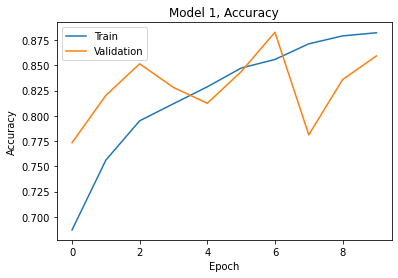

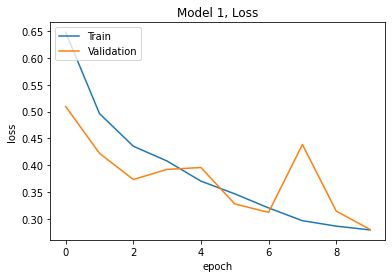

In [27]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1, Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1, Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


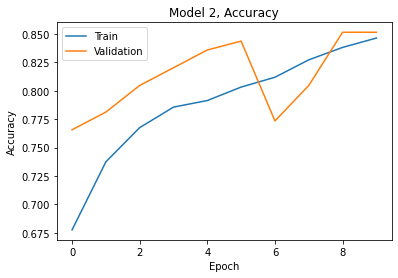

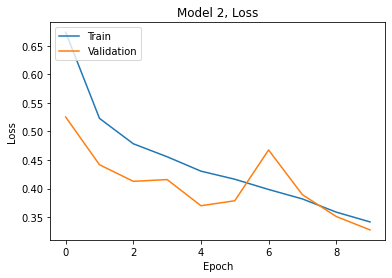

In [28]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2, Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2, Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Based on Accuracy-Epoch and Loss-Epoch curves above, we choose Model 1. 
Finally, we check performance on test set by calculating accuracy and confusion matrix:

In [32]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()

prob = model1.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)
y_pred = prob.argmax(axis=-1)

y_true = test_generator.labels
acc = np.mean(y_pred==y_true)

print('Accuracy:', acc)

print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))

140/140 [==============================] - 1s 4ms/step
Accuracy: 0.7785714285714286
Confusion matrix:
[[39 16]
 [15 70]]
